In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


## Importing Important Libraries

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from nltk.util import ngrams

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from numpy import random
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import gensim
import string
from gensim import corpora
from pprint import pprint
from gensim import models


from gensim.models import LdaModel, LdaMulticore

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [3]:
train_df= pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submissions=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")



## Text processing 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## missing values

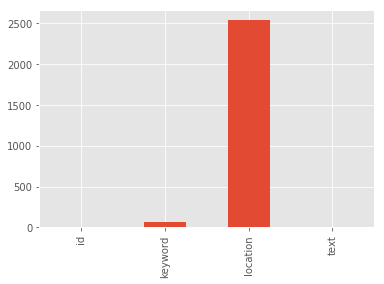

In [5]:

train_df.isnull().sum().plot(kind='bar')
test_df.isnull().sum().plot(kind='bar')

In [6]:
#Fetch wordcount for each abstract
train_df['wordcount'] = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','wordcount']].head()

,text,wordcount
0,Our Deeds are the Reason of this #earthquake M...,13
1,Forest fire near La Ronge Sask. Canada,7
2,All residents asked to 'shelter in place' are ...,22
3,"13,000 people receive #wildfires evacuation or...",9
4,Just got sent this photo from Ruby #Alaska as ...,17


In [32]:
#Descriptive statistics of word counts
train_df.wordcount.describe()

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: wordcount, dtype: float64

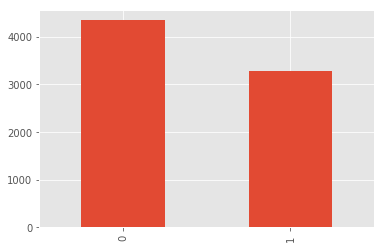

In [8]:
train_df['target'].value_counts()
train_df['target'].value_counts().plot(kind='bar')

## Structure analysis

In [10]:
document_lengths_train = np.array(list(map(len, train_df.text.str.split(' '))))
document_lengths_test = np.array(list(map(len, test_df.text.str.split(' '))))
print("The average number of words in a train document is: {}.".format(np.mean(document_lengths_train)))
print("The minimum number of words in a train document is: {}.".format(min(document_lengths_train)))
print("The maximum number of words in a train document is: {}.".format(max(document_lengths_train)))
print("The average number of words in a test document is: {}.".format(np.mean(document_lengths_test)))
print("The minimum number of words in a test document is: {}.".format(min(document_lengths_test)))
print("The maximum number of words in a test document is: {}.".format(max(document_lengths_test)))



The average number of words in a train document is: 14.928937344016813.
The minimum number of words in a train document is: 1.
The maximum number of words in a train document is: 54.
The average number of words in a test document is: 14.978853815507202.
The minimum number of words in a test document is: 1.
The maximum number of words in a test document is: 34.


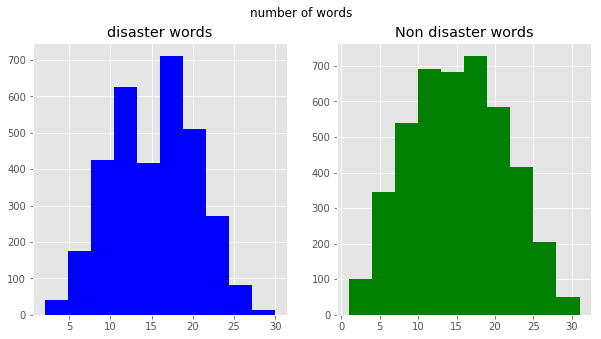

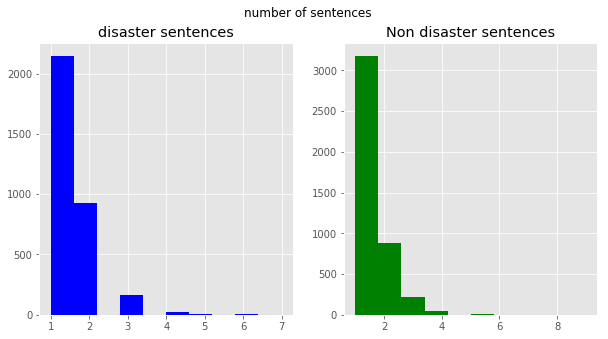

In [11]:
num_distwords =train_df[train_df['target']==1]['text'].apply(lambda x: len(x.split()))
num_nondistwords =train_df[train_df['target']==0]['text'].apply(lambda x: len(x.split()))
num_distsentences = train_df[train_df['target']==1]['text'].apply(lambda x: len(re.split( '~ ...' ,'~'.join(x.split('.')))))
num_nondistsentences = train_df[train_df['target']==0]['text'].apply(lambda x: len(re.split( '~ ...' ,'~'.join(x.split('.')))))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(num_distwords,color='blue')
ax1.set_title('disaster words')
ax2.hist(num_nondistwords,color='green')
ax2.set_title('Non disaster words')
fig.suptitle('number of words ')
plt.show()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(num_distsentences,color='blue')
ax1.set_title('disaster sentences')
ax2.hist(num_nondistsentences,color='green')
ax2.set_title('Non disaster sentences')
fig.suptitle('number of sentences ')
plt.show()

In [12]:
#unique_words = list(train_df['text'].str.lower().str.split(' ', expand=True).stack().unique())
unique_words_dist = list(train_df[train_df['target']==1]['text'].str.lower().str.split(' ', expand=True).stack().unique())
unique_words_nondist = list(train_df[train_df['target']==0]['text'].str.lower().str.split(' ', expand=True).stack().unique())

In [13]:
unique_words_dist[:10]



['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#earthquake',
 'may',
 'allah']

## Dataset Cleaning

In [14]:
import re
import string
def cleantext(text):
    url_regex=re.compile(r'https?://\S+|www\.\S+') 
    html_regex=re.compile(r'<.*?>')         
    text_after_removing_urls=url_regex.sub(r' ',text)
    text_after_removing_html_tags=html_regex.sub(r' ',text_after_removing_urls)
    text_removing_spcharar=re.sub(r'[Ã¥ÃŠÂ‰Ã›Ã¢ª]',' ',text)
    modified_string = re.sub(r'[^a-zA-Z0-9_\s]+', '', text)
    line = re.sub("(^|\W)\d+($|\W)", " ", text)
    removing_tags=re.sub(r',@","#","\w+"',' ',text) #removing tags
    final_text=text_after_removing_html_tags.lower()
    return final_text
                                       
    #url = text.lower()
   # url = text.split()
   # return url.sub(r'',text)

In [15]:
train_df["clean_text"] = train_df["text"].apply(lambda x : cleantext(x))
test_df["clean_text"] = test_df["text"].apply(lambda x : cleantext(x))


## Removing Stopwords,Punctuations and numbers

In [16]:
from nltk.corpus import stopwords
from string import punctuation
def remove_stop(text):
    output = '' .join(c for c in text if not c.isdigit())
    stop_free= " ".join([word for word in text.lower().split()if word not in (stopwords.words('english'))])
    return ''.join(p for p in text if p not in punctuation)
  #  return stop_free
    
train_df["clean_text"] = train_df["clean_text"].apply(lambda x : remove_stop(x))
test_df["clean_text"] = test_df["clean_text"].apply(lambda x : remove_stop(x)) 

## Stemming and Lemmitization

In [17]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
train_df['clean_text'].apply(lambda x:" ".join([lemmatizer.lemmatize(word)for word in x.split()]))
test_df['clean_text'].apply(lambda x:" ".join([lemmatizer.lemmatize(word)for word in x.split()]))
train_df['clean_text'].apply(lambda x:" ".join([stemmer.stem(word)for word in x.split()]))
test_df['clean_text'].apply(lambda x:" ".join([stemmer.stem(word)for word in x.split()]))


0                         just happen a terribl car crash
1       heard about earthquak is differ citi stay safe...
2       there is a forest fire at spot pond gees are f...
3                          apocalyps light spokan wildfir
4            typhoon soudelor kill 28 in china and taiwan
                              ...                        
3258     earthquak safeti lo angel ûò safeti fasten xrwn
3259    storm in ri wors than last hurrican my cityamp...
3260                         green line derail in chicago
3261                  meg issu hazard weather outlook hwo
3262    cityofcalgari ha activ it municip emerg plan y...
Name: clean_text, Length: 3263, dtype: object

## Removing emoji

In [18]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df["clean_text"] = train_df["clean_text"].apply(lambda x : remove_emoji(x))
test_df["clean_text"] = test_df["clean_text"].apply(lambda x : remove_emoji(x))

## worldcloud

In [19]:
worldcloud_dist=train_df[train_df['target']==1][['clean_text','target']]
worldcloud_nondist=train_df[train_df['target']==0][['clean_text','target']]


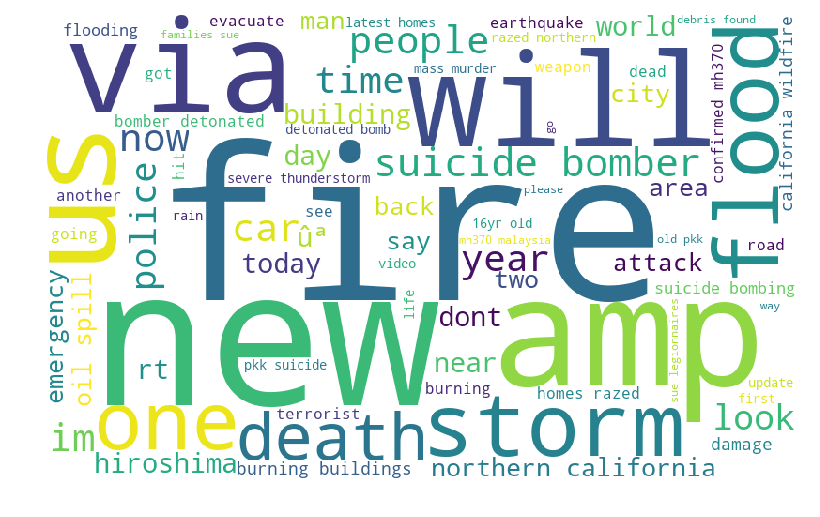

In [20]:
from wordcloud import WordCloud,STOPWORDS
comment_words= ' '
stopwords=set(STOPWORDS)
for val in worldcloud_dist.clean_text: 
    val=str(val)
    tokens=val.split()
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    for words in tokens:
        comment_words=comment_words+ words+' '

wordcloud = WordCloud(width = 800,height = 500,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(comment_words)        
plt.figure(figsize = (8, 8),facecolor = None,dpi=100) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)    
sns.set()


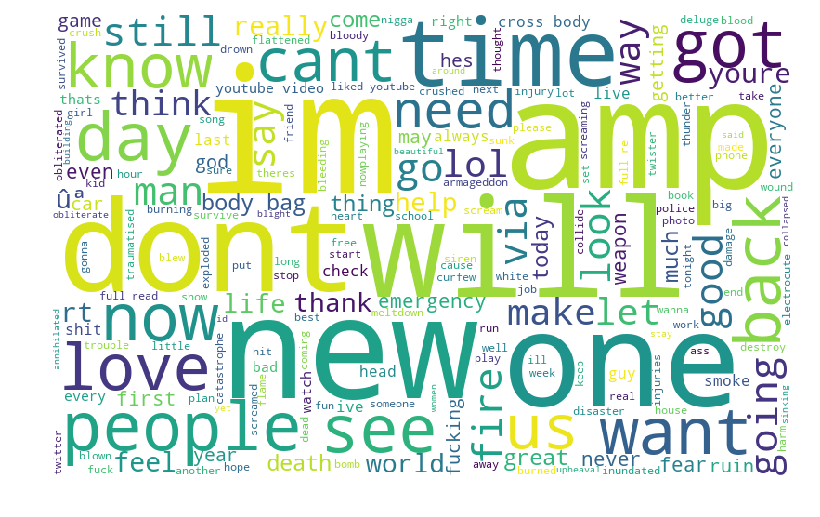

In [21]:

from wordcloud import WordCloud,STOPWORDS
non_comment_words= ' '
stopwords=set(STOPWORDS)
for val in worldcloud_nondist.clean_text: 
    val=str(val)
    tokens=val.split()
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    for words in tokens:
        non_comment_words=non_comment_words+ words+' '

wordcloud = WordCloud(width = 800,height = 500,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(non_comment_words)        
plt.figure(figsize = (8, 8),facecolor = None,dpi=100) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)    
sns.set()
      

## Vectorizer and TFIDF

In [34]:
cv = CountVectorizer(ngram_range=(1,2))
vectorized_train_df = cv.fit_transform(train_df['clean_text'])#.toarray()


In [37]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1',ngram_range=(1, 2), stop_words='english')
tfidf_train_df = tfidf.fit_transform(train_df['clean_text']).toarray()
features_list=tfidf.get_feature_names()[:100]

In [39]:
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(vectorized_train_df, train_df['target'], test_size=0.2, random_state=0)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_train_df, train_df['target'], test_size=0.2, random_state=0)
sentences_train, sentences_test, y_train, y_test = train_test_split(train_df['clean_text'], train_df['target'], test_size=0.25, random_state=1000)

## Logistic Regression with Vectorization

In [41]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
logit = LogisticRegression(random_state=17,n_jobs=-1, solver='lbfgs')
%time
logit.fit(X_train_vec, y_train_vec)


print('accuracy %s' % accuracy_score(y_test_vec, logit.predict(X_test_vec)), 3)
print('AUC %s' % roc_auc_score(y_test_vec, logit.predict(X_test_vec)), 3)
print(classification_report(y_test_vec, logit.predict(X_test_vec)), 3)



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
accuracy 0.8082731451083388 3
AUC 0.7904336070250292 3
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       886
           1       0.83      0.68      0.75       637

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523
 3


## Logistic Regression with Tfidf

In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
## Apply Logistic Regression algorithum
logreg = LogisticRegression(random_state=17,n_jobs=-1, solver='lbfgs')
%time
logreg.fit(X_train_tf, y_train_tf)



print('accuracy %s' % accuracy_score(y_test_tf, logreg.predict(X_test_tf)), 3)
print('AUC %s' % roc_auc_score(y_test_tf,logreg.predict(X_test_tf)), 3)
print(classification_report(y_test_tf, logreg.predict(X_test_tf)), 3)
 

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 31.2 µs
accuracy 0.8003939592908733 3
AUC 0.7796908831252589 3
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       886
           1       0.83      0.65      0.73       637

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523
 3


## Naive Bayes with Vectorization

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time
nb.fit(X_train_vec, y_train_vec)


print('accuracy %s' % accuracy_score(y_test_vec, nb.predict(X_test_vec)), 3)
print('AUC %s' % roc_auc_score(y_test_vec, nb.predict(X_test_vec)), 3)
print(classification_report(y_test_vec, nb.predict(X_test_vec)), 3)

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 14.8 µs
accuracy 0.7964543663821405 3
AUC 0.7855698799749107 3
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       886
           1       0.78      0.72      0.75       637

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523
 3


## Mutinomial Bayes with Tfidf

In [29]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time
nb.fit(X_train_tf, y_train_tf)

print('accuracy %s' % accuracy_score(y_test_tf, nb.predict(X_test_tf)), 3)
print('AUC %s' % roc_auc_score(y_test_tf,nb.predict(X_test_tf)), 3)
print(classification_report(y_test_tf, nb.predict(X_test_tf)), 3)


CPU times: user 168 µs, sys: 25 µs, total: 193 µs
Wall time: 90.1 µs
accuracy 0.7872619829284307 3
AUC 0.7648746770804172 3
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       886
           1       0.82      0.63      0.71       637

    accuracy                           0.79      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.79      0.79      0.78      1523
 3


## Gradient Boosting with Vectorization

In [30]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
%time
gb=GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 300,
                                                   max_depth = 3,
                                                   random_state=17)
gb.fit(X_train_vec, y_train_vec)

print('accuracy %s' % accuracy_score(y_test_vec, gb.predict(X_test_vec)), 3)
print('AUC %s' % roc_auc_score(y_test_vec, gb.predict(X_test_vec)), 3)
print(classification_report(y_test_vec, gb.predict(X_test_vec)), 3)

CPU times: user 24 µs, sys: 3 µs, total: 27 µs
Wall time: 14.5 µs
accuracy 0.6881155613919895 3
AUC 0.6514240354936904 3
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       886
           1       0.71      0.43      0.53       637

    accuracy                           0.69      1523
   macro avg       0.70      0.65      0.65      1523
weighted avg       0.69      0.69      0.67      1523
 3


## Gradient Boosting with Tfidf

In [31]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
%time
gb=GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 300,
                                                   max_depth = 3,
                                                   random_state=17)
gb.fit(X_train_tf, y_train_tf)

#predictions = gb.predict(X_test_sparse)
print('accuracy %s' % accuracy_score(y_test_tf, gb.predict(X_test_tf)), 3)
print('AUC %s' % roc_auc_score(y_test_tf,gb.predict(X_test_tf)), 3)
print(classification_report(y_test_tf, gb.predict(X_test_tf)), 3)


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs


KeyboardInterrupt: 

## Random Forest with Vecterization

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec, y_train_vec)

print('accuracy %s' % accuracy_score(y_test_vec, rf.predict(X_test_vec)), 3)
print('AUC %s' % roc_auc_score(y_test_vec, rf.predict(X_test_vec)), 3)
print(classification_report(y_test_vec, rf.predict(X_test_vec)), 3)

## Random Forest with Tfidf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tf, y_train_tf)

print('accuracy %s' % accuracy_score(y_test_tf, rf.predict(X_test_tf)), 3)
print('AUC %s' % roc_auc_score(y_test_tf,rf.predict(X_test_tf)), 3)
print(classification_report(y_test_tf, rf.predict(X_test_tf)), 3)

## Roc Curve of classification models with vectorization

In [ ]:

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=17,n_jobs=-1, solver='lbfgs'), 
               MultinomialNB(),
                RandomForestClassifier(n_estimators=100),
                GradientBoostingClassifier(loss = 'deviance',
                                           learning_rate = 0.01,
                                           n_estimators = 100,
                                           max_depth = 5,
                                           random_state=17)] 

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_vec, y_train_vec)
    yproba = model.predict_proba(X_test_vec)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_vec,  yproba)
    auc = roc_auc_score(y_test_vec, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=17,n_jobs=-1, solver='lbfgs'), 
               MultinomialNB(),
                RandomForestClassifier(n_estimators=100),
                GradientBoostingClassifier(loss = 'deviance',
                                           learning_rate = 0.01,
                                           n_estimators = 100,
                                           max_depth = 5,
                                           random_state=17)] 

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_tf, y_train_tf)
    yproba = model.predict_proba(X_test_tf)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_tf,  yproba)
    auc = roc_auc_score(y_test_tf, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 110,521
Trainable params: 110,521
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9399
Testing Accuracy:  0.7800


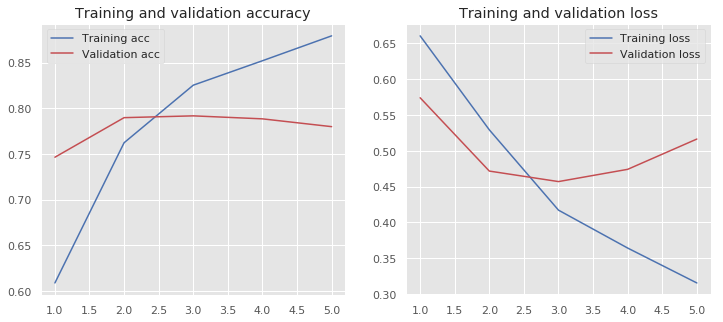

In [42]:
from keras.models import Sequential
from keras import layers

input_dim = X_train_tf.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
# compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

#print the results
history = model.fit(X_train_tf, y_train_tf,epochs=5,verbose=False,validation_data=(X_test_tf, y_test_tf),batch_size=10)
loss, accuracy = model.evaluate(X_train_tf, y_train_tf, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tf, y_test_tf, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

#plot the results
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)


## Word Embeddings

In [61]:
train_df['wordcount'].max()

54

all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
[95, 622, 827, 738, 2778, 3648, 115, 4, 3649, 2262]
[ 259  282  273    9 1165  331    3  439  380 3647 1009 1708    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Shape of X train and X validation tensor: (5709, 54) (1904, 54)
Shape of label train and validation tensor: (5709,) (1904,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 54, 50)            754350    
_________________________________________________________________
flatten_5 (Flatten)          (None, 2700)              0         
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 0.9776
Testing Accuracy:  0.7826


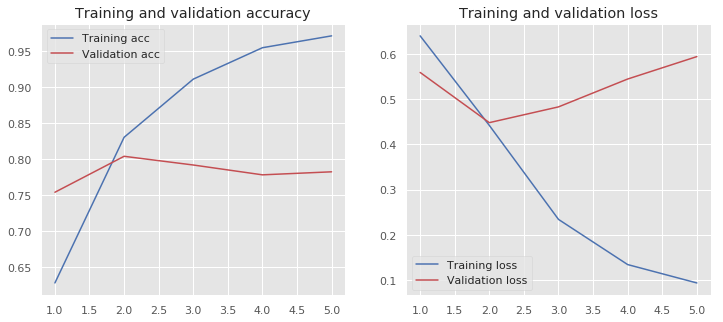

In [62]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])
from keras.preprocessing.sequence import pad_sequences

maxlen=train_df['wordcount'].max()


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
print('Shape of X train and X validation tensor:', X_train.shape,X_test.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_test.shape)

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)



## Embeddings with maxpooling

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=4,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [64]:
maxlen

54

In [73]:
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
#embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size,10000, input_length=maxlen,trainable=False,mask_zero=True))
#Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))
#model.add(layers.RNN(128, 5, activation='relu'))
model.add(LSTM(10, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# Dropout for regularization
model.add(Dropout(0.5))
# Output layer
model.add(Dense(1, activation='softmax'))


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()








Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 54, 10000)         150870000 
_________________________________________________________________
masking_7 (Masking)          (None, 54, 10000)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                400440    
_________________________________________________________________
dense_32 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 11        
_________________________________________________________________
dropout_9 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

Training Accuracy: 0.4323
Testing Accuracy:  0.4217


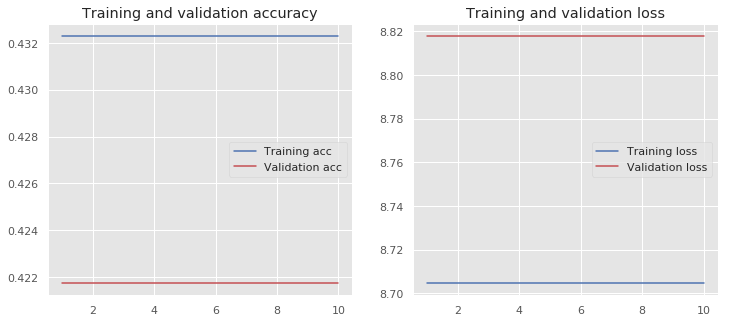

In [70]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
embedding_dim = 50
model = Sequential()

# Embedding layer
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen,trainable=False,mask_zero=False))
# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=4,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
sequences_test=tokenizer.texts_to_sequences(sentences_validation)
X_testt = pad_sequences(sequences_test,maxlen=X_train.shape[1])
y_predd=model.predict(X_testt)


In [ ]:
test_df['target']=round(test_df['target']) 

In [ ]:
test_df[['id','target']].to_csv('Convolutional Neural Network.csv',index=False)